# Exploring Trends in the NSDUH Data Set

In [161]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import thinkstats2 as ts
import thinkplot

oxy_file = 'oxy.hdf5'

For this project, I'm exploring the 2014 NSDUH series data to look for trends in OxyContin use.

The survey series can be found on the [SAMHDA website](https://www.datafiles.samhsa.gov/study-series/national-survey-drug-use-and-health-nsduh-nid13517).

The codebook and data for 2014 can be found on [this page](https://www.datafiles.samhsa.gov/study-dataset/national-survey-drug-use-and-health-2014-nsduh-2014-ds0001-nid16876)

The terms of use for this data can be found on the [SAMHDA website's terms of use page](https://www.datafiles.samhsa.gov/info/terms-use-nid3422)

## Load data

First, read in all of the data for 2014. Then, we'll look at some interesting variables and create a smaller data frame that only contains the variables we analyzed to save and load in the future.

In [162]:
nsduh2014 = pd.read_stata('nsduh_data/NSDUH_2014.DTA')
nsduh2014.head()

,QUESTID2,filedate,cigever,cigofrsm,cigwilyr,cigtry,cigyfu,cigmfu,cigrec,CIG30USE,...,II2EMST4,prxretry,prxydata,PDEN10,COUTYP2,MAIIN102,AIIND102,ANALWT_C,vestr,verep
0,52395143,09/07/2018,2 - No,99 - LEGITIMATE SKIP,99 - LEGITIMATE SKIP,991 - NEVER USED CIGARETTES,9991 - NEVER USED CIGARETTES,91 - NEVER USED CIGARETTES,91 - NEVER USED CIGARETTES,91 - NEVER USED CIGARETTES,...,1 - Employment status from questionnaire,99 - LEGITIMATE SKIP,1 - Yes,2 - Segm. in a CBSA with fewer than 1 million ...,2 - Small Metro,2 - Segment not in an American Indian area,2 - Census block not in an American Indian area,3752.054717,40035,2
1,85095143,09/07/2018,1 - Yes,99 - LEGITIMATE SKIP,99 - LEGITIMATE SKIP,21,9999 - LEGITIMATE SKIP,99 - LEGITIMATE SKIP,1 - Within the past 30 days,30,...,1 - Employment status from questionnaire,98 - BLANK,98 - BLANK,2 - Segm. in a CBSA with fewer than 1 million ...,3 - Nonmetro,2 - Segment not in an American Indian area,2 - Census block not in an American Indian area,4594.635570,40029,2
2,93625143,09/07/2018,1 - Yes,99 - LEGITIMATE SKIP,99 - LEGITIMATE SKIP,20,9999 - LEGITIMATE SKIP,99 - LEGITIMATE SKIP,2 - More than 30 days ago but within the past ...,93 - DID NOT USE CIGARETTES IN THE PAST 30 DAYS,...,1 - Employment status from questionnaire,99 - LEGITIMATE SKIP,99 - LEGITIMATE SKIP,2 - Segm. in a CBSA with fewer than 1 million ...,3 - Nonmetro,2 - Segment not in an American Indian area,2 - Census block not in an American Indian area,1559.493270,40009,2
3,92725143,09/07/2018,2 - No,4 - Definitely Not,4 - Definitely Not,991 - NEVER USED CIGARETTES,9991 - NEVER USED CIGARETTES,91 - NEVER USED CIGARETTES,91 - NEVER USED CIGARETTES,91 - NEVER USED CIGARETTES,...,9 - 12-17 years old,99 - LEGITIMATE SKIP,1 - Yes,2 - Segm. in a CBSA with fewer than 1 million ...,2 - Small Metro,2 - Segment not in an American Indian area,2 - Census block not in an American Indian area,1188.289263,40024,2
4,85235143,09/07/2018,1 - Yes,99 - LEGITIMATE SKIP,99 - LEGITIMATE SKIP,18,9999 - LEGITIMATE SKIP,99 - LEGITIMATE SKIP,3 - More than 12 months ago but within the pas...,93 - DID NOT USE CIGARETTES IN THE PAST 30 DAYS,...,1 - Employment status from questionnaire,99 - LEGITIMATE SKIP,1 - Yes,2 - Segm. in a CBSA with fewer than 1 million ...,2 - Small Metro,2 - Segment not in an American Indian area,2 - Census block not in an American Indian area,3029.730498,40041,1


## Prescription Opioids
The most common opiods incvolved in prescription overdose death are Metadone, Oxycodone, and Hydrocodone [according to the CDC](https://www.cdc.gov/drugoverdose/opioids/prescribed.html). I'm going to specifically look at oxycontin because the NSDUH survey provides the most questions targetted at its use as a painkiller.

### Prepare the data

For the 2014 survey, the questions pertaining to OxyContin use are:

* 'oxycage': AGE WHEN FIRST USED OXYCONTIN NONMEDICALLY\*
* 'oxycrec': TIME SINCE LAST USED OXYCONTIN NONMEDICALLY\*
* 'oxyyrtot': TOTAL # DAYS USED OXYCONTIN PAST 12 MONTHS
* 'oxdaypyr': # DAYS USED OXYCONTIN "NM" PAST 12 MONTHS

\* "Nonmedically" is defined as usage of the drug that was not prescribed for the individual or usage only for the experience or feeling it caused.

Other useful categories for analysis are:

* 'AGE2': RECODE - FINAL EDITED AGE
    * Note included with description in codebook: After a respondent has entered his/her birthdate in the first part of the questionnaire, he/she has multiple opportunities to change his/her age in response to consistency checks throughout the questionnaire. It is therefore possible for the age recorded by the respondent at the beginning of the questionnaire to be different than the age at the end of the questionnaire. The final age variable is determined using these two constituent age variables, in addition to the age calculated from the raw birthdate and the final edited interview date, the age entered in the questionnaire roster (if it exists), and the pre-interview screener age.
* 'ANALWT_3': the weight can be interpreted as representing the total number of target population individuals each record on the file represents

The Series in this data set are categorical, so we need to do some careful mapping to put the variables we want into a usable format. Because the categorical labels are fairly consistently formatted, we can define a function to map the categories to usable integers.

In [163]:
def map_cat_to_int(variable):
    """Creates a mapping from a categorical label to an integer.
    
    Args:
        variable (pandas Series): The categorical variable to map.
    
    Returns:
        cat_dict (dictionary): A dictionary with keys as the categorical
            labels and values as the integers corresponding to the label.
        mapped_variable (pandas Series): The variable with categorical 
            labels replaced with integers.
    """
    categories = list(variable.cat.categories)
    
    cat_dict = {}
    
    for cat in categories:
        if isinstance(cat, int):
            cat_dict[cat] = cat
        else:
            code = int(cat.split(" ")[0])
            cat_dict[cat] = code
    
    mapped_variable = variable.map(cat_dict)
    return cat_dict, mapped_variable

#### Age

`AGE2` is categorical, so we have to make a mapping to get the integer values of the codes.

In [164]:
age = nsduh2014['AGE2']

Make a dictionary to map these codes to the corresponding integers and perform the mapping.

In [165]:
age_cat_dict, age = map_cat_to_int(age)
print(age_cat_dict)
age.head()

{'1 - Respondent is 12 years old': 1, '2 - Respondent is 13 years old': 2, '3 - Respondent is 14 years old': 3, '4 - Respondent is 15 years old': 4, '5 - Respondent is 16 years old': 5, '6 - Respondent is 17 years old': 6, '7 - Respondent is 18 years old': 7, '8 - Respondent is 19 years old': 8, '9 - Respondent is 20 years old': 9, '10 - Respondent is 21 years old': 10, '11 - Respondent is 22 or 23 years old': 11, '12 - Respondent is 24 or 25 years old': 12, '13 - Respondent is between 26 and 29 years old': 13, '14 - Respondent is between 30 and 34 years old': 14, '15 - Respondent is between 35 and 49 years old': 15, '16 - Respondent is between 50 and 64 years old': 16, '17 - Respondent is 65 years old or older': 17}


0     7
1    15
2    14
3     5
4     9
Name: AGE2, dtype: int64

#### Weight

The weight variable weight isn't categorical, so we can leave it as is for now.

In [166]:
weight = nsduh2014['ANALWT_C']
weight.dtype

dtype('float64')

#### OXYCAGE: AGE WHEN FIRST USED OXYCONTIN NONMEDICALLY

`OXYCAGE` is categorical, so we have to process it the same way as for `AGE2`

In [167]:
oxycage = nsduh2014['oxycage']

In [168]:
oxycage_cat_dict, oxycage = map_cat_to_int(oxycage)
print(oxycage_cat_dict)
oxycage.describe()

{2: 2, 7: 7, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 55: 55, 57: 57, 60: 60, '981 - NEVER USED OXYCONTIN Logically assigned': 981, '985 - BAD DATA Logically assigned': 985, '991 - NEVER USED OXYCONTIN': 991, '994 - DON T KNOW': 994, '997 - REFUSED': 997, '998 - BLANK': 998}


count    55271.000000
mean       960.178140
std        169.020101
min          2.000000
25%        991.000000
50%        991.000000
75%        991.000000
max        998.000000
Name: oxycage, dtype: float64

#### OXYCREC: TIME SINCE LAST USED OXYCONTIN NONMEDICALLY

`OXYCREC` is categorical too.

In [169]:
oxycrec = nsduh2014['oxycrec']

In [170]:
oxycrec_cat_dict, oxycrec = map_cat_to_int(oxycrec)
print(oxycrec_cat_dict)
oxycrec.describe()

{'1 - Within the past 30 days': 1, '2 - More than 30 days ago but within the past 12 mos': 2, '3 - More than 12 months ago': 3, '8 - Used at some point in the past 12 mos LOG ASSN': 8, '9 - Used at some point in lifetime LOG ASSN': 9, '11 - Used in the past 30 days LOGICALLY ASSIGNED': 11, '81 - NEVER USED OXYCONTIN Logically assigned': 81, '85 - BAD DATA Logically assigned': 85, '91 - NEVER USED OXYCONTIN': 91, '97 - REFUSED': 97, '98 - BLANK': 98}


count    55271.000000
mean        87.781857
std         15.588913
min          1.000000
25%         91.000000
50%         91.000000
75%         91.000000
max         98.000000
Name: oxycrec, dtype: float64

#### OXYYRTOT: TOTAL # DAYS USED OXYCONTIN PAST 12 MONTHS

In [171]:
oxyyrtot = nsduh2014['oxyyrtot']

In [172]:
oxyyrtot_cat_dict, oxyyrtot = map_cat_to_int(oxyyrtot)
print(oxyyrtot_cat_dict)
print(oxyyrtot.describe())

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 28: 28, 29: 29, 30: 30, 35: 35, 36: 36, 37: 37, 43: 43, 45: 45, 46: 46, 48: 48, 49: 49, 50: 50, 52: 52, 60: 60, 72: 72, 84: 84, 90: 90, 96: 96, 97: 97, 104: 104, 108: 108, 115: 115, 120: 120, 139: 139, 140: 140, 144: 144, 155: 155, 156: 156, 168: 168, 180: 180, 192: 192, 204: 204, 206: 206, 208: 208, 240: 240, 250: 250, 252: 252, 260: 260, 312: 312, 330: 330, 336: 336, 360: 360, 364: 364, '981 - NEVER USED OXYCONTIN Logically assigned': 981, '985 - BAD DATA Logically assigned': 985, '991 - NEVER USED OXYCONTIN': 991, '993 - DID NOT USE OXYCONTIN IN THE PAST 12 MOS': 993, '994 - DON T KNOW': 994, '997 - REFUSED': 997, '998 - BLANK': 998}
count    55271.000000
mean       985.009155
std         73.033914
min          1.000000
25%        991.000000
50%        991.000000
75%        991.000000
max        998.000000
Name: oxyyrt

#### OXDAYPYR: DAYS USED OXYCONTIN "NM" PAST 12 MONTHS

In [173]:
oxdaypyr = nsduh2014['oxdaypyr']
oxdaypyr.describe()

count                          55271
unique                            30
top       991 - NEVER USED OXYCONTIN
freq                           51125
Name: oxdaypyr, dtype: object

In [174]:
oxdaypyr_cat_dict, oxdaypyr = map_cat_to_int(oxdaypyr)
print(oxdaypyr_cat_dict)
oxdaypyr.describe()

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 12: 12, 13: 13, 14: 14, 15: 15, 20: 20, 24: 24, 30: 30, 45: 45, 50: 50, 90: 90, 140: 140, 330: 330, '981 - NEVER USED OXYCONTIN Logically assigned': 981, '985 - BAD DATA Logically assigned': 985, '989 - LEGITIMATE SKIP Logically assigned': 989, '991 - NEVER USED OXYCONTIN': 991, '993 - DID NOT USE OXYCONTIN IN THE PAST 12 MOS': 993, '997 - REFUSED': 997, '998 - BLANK': 998, '999 - LEGITIMATE SKIP': 999}


count    55271.000000
mean       987.419479
std         56.636641
min          1.000000
25%        991.000000
50%        991.000000
75%        991.000000
max        999.000000
Name: oxdaypyr, dtype: float64

### Clean and keep usable variables

The variables that we found to have potential for analysis are `ANAlWT_C`, `AGE2`, `OXYCAGE`, `OXYCREC`, `OXYYRTOT`, and `OXYDAYPYR`. Let's clean up these variables and save them in a data frame for further analysis.

#### OXYCAGE

First, let's replace all of the codes corresponding to missing or unusable data.

In [175]:
print(oxycage_cat_dict)

{2: 2, 7: 7, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 55: 55, 57: 57, 60: 60, '981 - NEVER USED OXYCONTIN Logically assigned': 981, '985 - BAD DATA Logically assigned': 985, '991 - NEVER USED OXYCONTIN': 991, '994 - DON T KNOW': 994, '997 - REFUSED': 997, '998 - BLANK': 998}


The codes to replace with NaNs in this case are all of the 900 codes. This is because we want to know the ages at which people who HAVE used OxyContin at all tried it nonmedically for the first time.

In [176]:
replace_codes = [981, 985, 991, 994, 997, 998]
oxycage = oxycage.replace(replace_codes, np.nan)

#### OXYCREC

In [177]:
print(oxycrec_cat_dict)

{'1 - Within the past 30 days': 1, '2 - More than 30 days ago but within the past 12 mos': 2, '3 - More than 12 months ago': 3, '8 - Used at some point in the past 12 mos LOG ASSN': 8, '9 - Used at some point in lifetime LOG ASSN': 9, '11 - Used in the past 30 days LOGICALLY ASSIGNED': 11, '81 - NEVER USED OXYCONTIN Logically assigned': 81, '85 - BAD DATA Logically assigned': 85, '91 - NEVER USED OXYCONTIN': 91, '97 - REFUSED': 97, '98 - BLANK': 98}


This variable takes a little more work because of the way it is coded. There are some categories that are the same aside from if they are or aren't 'LOGICALLY ASSIGNED'. The logically assigned variables mean that the answer to the question was inferred from information from other questions. I want to group these categories together, recode some of the category numbers for easier visualization later, and replace missing or unusable data with NaNs.

First, replace all of the codes corresponding to missing data in `OXYCREC` with NaNs.

In [178]:
replace_codes = [85, 97, 98]
oxycrec = mapped_oxycrec.replace(replace_codes, np.nan)

Now, let's group the "never used" categories together and reassign some of the other codes for easier graphing later.

In [179]:
# Group logically assigned category with the rest of 'within 30 days'
oxycrec = oxycrec.replace([11], 1)

# Shift the labels of these categories for better visualization later.
oxycrec = oxycrec.replace([8], 4)
oxycrec = oxycrec.replace([9], 5)

# Group the 'never used' categories together.
oxycrec = oxycrec.replace([81, 91], 6)

#### OXYYRTOT

In [180]:
print(oxyyrtot_cat_dict)

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 28: 28, 29: 29, 30: 30, 35: 35, 36: 36, 37: 37, 43: 43, 45: 45, 46: 46, 48: 48, 49: 49, 50: 50, 52: 52, 60: 60, 72: 72, 84: 84, 90: 90, 96: 96, 97: 97, 104: 104, 108: 108, 115: 115, 120: 120, 139: 139, 140: 140, 144: 144, 155: 155, 156: 156, 168: 168, 180: 180, 192: 192, 204: 204, 206: 206, 208: 208, 240: 240, 250: 250, 252: 252, 260: 260, 312: 312, 330: 330, 336: 336, 360: 360, 364: 364, '981 - NEVER USED OXYCONTIN Logically assigned': 981, '985 - BAD DATA Logically assigned': 985, '991 - NEVER USED OXYCONTIN': 991, '993 - DID NOT USE OXYCONTIN IN THE PAST 12 MOS': 993, '994 - DON T KNOW': 994, '997 - REFUSED': 997, '998 - BLANK': 998}


For this variable, I want to do two replacements. The first is to replace missing or unusable data with NaNs. The second is to replace and of the categories that indicate that someone hadn't used OxyContin in the past year with 0s.

First, replace the missing data.

In [181]:
replace_codes = [985, 994, 997, 998]
oxyyrtot = oxyyrtot.replace(replace_codes, np.nan)

In [182]:
replace_codes = [981, 991, 993]
oxyyrtot = oxyyrtot.replace(replace_codes, 0)

#### OXDAYPYR

In [183]:
print(oxdaypyr_cat_dict)

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 12: 12, 13: 13, 14: 14, 15: 15, 20: 20, 24: 24, 30: 30, 45: 45, 50: 50, 90: 90, 140: 140, 330: 330, '981 - NEVER USED OXYCONTIN Logically assigned': 981, '985 - BAD DATA Logically assigned': 985, '989 - LEGITIMATE SKIP Logically assigned': 989, '991 - NEVER USED OXYCONTIN': 991, '993 - DID NOT USE OXYCONTIN IN THE PAST 12 MOS': 993, '997 - REFUSED': 997, '998 - BLANK': 998, '999 - LEGITIMATE SKIP': 999}


Finally, let's perform a similar cleaning as with `OXYYRTOT` because the variables are very similar.

Replace missing or unusable data with NaNs

In [184]:
replace_codes = [985, 989, 997, 998, 999]
oxdaypyr = oxdaypyr.replace(replace_codes, np.nan)

Replace codes that indicate someone hasn't used in the past year or more with 0s.

In [185]:
replace_codes = [981, 991, 993]
oxdaypyr = oxdaypyr.replace(replace_codes, 0)

### Creating and Saving the DataFrame

Now that all of the data is cleaned and converted to numerical values, we can put it all together into one data frame, adjust the weights, and save the data for fast loading later.

First, concatenate the individual series.

In [188]:
variables = [age, weight, oxycage, oxycrec, oxyyrtot, oxdaypyr]
oxy_df = pd.concat(variables, axis=1, sort=True)
oxy_df.head()

,AGE2,ANALWT_C,oxycage,oxycrec,oxyyrtot,oxdaypyr
0,7,3752.054717,NaN,6.0,0.0,0.0
1,15,4594.635570,NaN,6.0,0.0,0.0
2,14,1559.493270,NaN,6.0,0.0,0.0
3,5,1188.289263,NaN,6.0,0.0,0.0
4,9,3029.730498,NaN,6.0,0.0,0.0


Now, let's resample the data according to the weights. The following code was adapted from Think Stats Chapter 10.7

In [196]:
# def ResampleRowsWeighted(df, column='finalwgt'):
# weights = df[column]
# cdf = Cdf(dict(weights))
# indices = cdf.Sample(len(weights))
# sample = df.loc[indices]
# return sample

weights = oxy_df['ANALWT_C']
cdf_weights = ts.Cdf(dict(weights))
indices = cdf_weights.Sample(len(weights))
oxy_df_resample = oxy_df.loc[indices]
oxy_df_resample.head()

,AGE2,ANALWT_C,oxycage,oxycrec,oxyyrtot,oxdaypyr
14611,15,10178.757989,NaN,6.0,0.0,0.0
8652,15,566.840282,NaN,6.0,0.0,0.0
32323,17,14112.484590,NaN,6.0,0.0,0.0
45782,15,5211.059304,NaN,6.0,0.0,0.0
24162,12,4559.533805,NaN,6.0,0.0,0.0


Finally, let's save the new data frame to an hdf file for quicker loading later.

In [198]:
oxy_df.to_hdf('oxy_df.hdf5', key='oxy_df')
oxy_df_resample.to_hdf('oxy_df_resample.hdf5', key='oxy_df_resample')

## Look at Individual Variables

Let's look at the individual variables first to get an idea of what questions we may be able to answer.

### AGE2

To get a general idea of the distribution of age categories, let's look at the PMF and CDF of the raw categories.

In [200]:
age_cat_dict

{'1 - Respondent is 12 years old': 1,
 '2 - Respondent is 13 years old': 2,
 '3 - Respondent is 14 years old': 3,
 '4 - Respondent is 15 years old': 4,
 '5 - Respondent is 16 years old': 5,
 '6 - Respondent is 17 years old': 6,
 '7 - Respondent is 18 years old': 7,
 '8 - Respondent is 19 years old': 8,
 '9 - Respondent is 20 years old': 9,
 '10 - Respondent is 21 years old': 10,
 '11 - Respondent is 22 or 23 years old': 11,
 '12 - Respondent is 24 or 25 years old': 12,
 '13 - Respondent is between 26 and 29 years old': 13,
 '14 - Respondent is between 30 and 34 years old': 14,
 '15 - Respondent is between 35 and 49 years old': 15,
 '16 - Respondent is between 50 and 64 years old': 16,
 '17 - Respondent is 65 years old or older': 17}

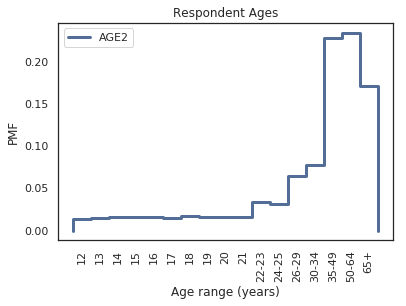

In [232]:
ticks = [i for i in range(1, 18)]
labels = ['12', '13', '14', '15', '16', '17',
          '18', '19', '20', '21', '22-23', '24-25',
          '26-29', '30-34', '35-49', '50-64', '65+']

pmf_age_cats = ts.Pmf(oxy_df_resample['AGE2'])

thinkplot.Pmf(pmf_age_cats, label='AGE2')

plt.xticks(ticks, labels, rotation=90)
plt.ylabel('PMF')
plt.xlabel('Age range (years)')
plt.title('Respondent Ages')
plt.legend()
plt.savefig('figures/age2_pmf.png')


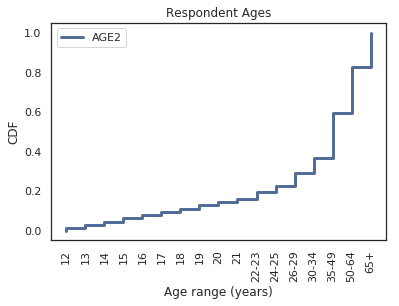

In [233]:
cdf_age_cats = ts.Cdf(oxy_df_resample['AGE2'])

thinkplot.Cdf(cdf_age_cats, label='AGE2')

plt.xticks(ticks, labels, rotation=90)
plt.ylabel('CDF')
plt.xlabel('Age range (years)')
plt.title('Respondent Ages')
plt.legend()
plt.savefig('figures/age2_cdf.png')

It looks like respondents are more likely to be over 35. I want to also see what this distribution looks like with the younger ages grouped together more, just to get a better sense of how many young people are represented.

In [234]:
# Compress the respondents under 20 into one group, 
# and the respondents in their 20s into another group.
group_map = {1:12, 2:12, 3:12, 4:12, 5:12, 6:12, 7:12, 8:12,
            9:13, 10:13, 11:13, 12:13,
            14:14, 15:15, 16:16, 17:17}
age_grouped = oxy_df_resample['AGE2'].map(group_map)

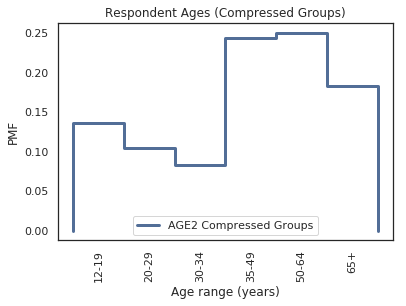

In [235]:
ticks = [i for i in range(12, 18)]
labels = ['12-19', '20-29', '30-34', '35-49', '50-64', '65+']

pmf_age_grouped = ts.Pmf(age_grouped)

thinkplot.Pmf(pmf_age_grouped, label='AGE2 Compressed Groups')

plt.xticks(ticks, labels, rotation=90)
plt.ylabel('PMF')
plt.xlabel('Age range (years)')
plt.title('Respondent Ages (Compressed Groups)')
plt.legend()
plt.savefig('figures/age2_grouped_pmf.png')

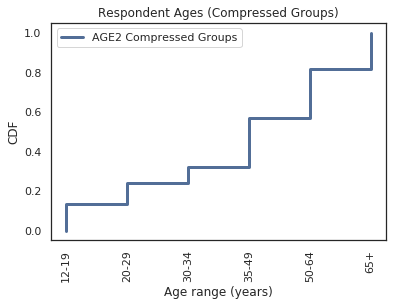

In [236]:
cdf_age_grouped = ts.Cdf(age_grouped)

thinkplot.Cdf(cdf_age_grouped, label='AGE2 Compressed Groups')

plt.xticks(ticks, labels, rotation=90)
plt.ylabel('CDF')
plt.xlabel('Age range (years)')
plt.title('Respondent Ages (Compressed Groups)')
plt.legend()
plt.savefig('figures/age2_grouped_cdf.png')

This sample looks a little more uniform in distribution now that the groups for the younger ages are larger, as can be seem by the CDF looking approximately straight.

### OXYCAGE: AGE WHEN FIRST USED OXYCONTIN NONMEDICALLY

Just like before, let's see what the PMF and CDF of `OXYCAGE` look like to get a sense of the distribution. Recall that the cleaned data only contains valid ages, so this is only representative of people who have ever tried OxyContin non-medically in their lives.

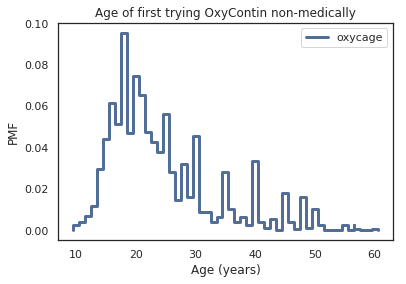

In [237]:
pmf_oxycage = ts.Pmf(oxy_df_resample['oxycage'])
thinkplot.Pmf(pmf_oxycage, label='oxycage')
plt.ylabel('PMF')
plt.xlabel('Age (years)')
plt.title("Age of first trying OxyContin non-medically")
plt.legend()
plt.savefig('figures/oxycage_pmf.png')

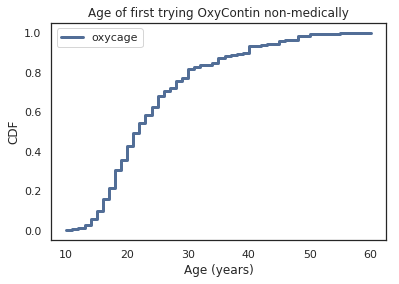

In [238]:
cdf_oxycage = ts.Cdf(oxy_df_resample['oxycage'])
thinkplot.Cdf(cdf_oxycage, label='oxycage')
plt.ylabel('CDF')
plt.xlabel('Age (years)')
plt.title("Age of first trying OxyContin non-medically")
plt.legend()
plt.savefig('figures/oxycage_cdf.png')

In [317]:
median = cdf_oxycage.Value(.5)
iqr = cdf_oxycage.Value(0.75) - cdf_oxycage.Value(0.25)
mean = pmf_oxycage.Mean()
perc_25 = cdf_oxycage.Value(0.25)
perc_75 = cdf_oxycage.Value(0.75)

print("Median: {}, 25th Percentile: {}, 75th Percentile: {}, IQR: {}, Mean: {}".format(median, perc_25, perc_75, iqr, mean))

Median: 22.0, 25th Percentile: 18.0, 75th Percentile: 28.0, IQR: 10.0, Mean: 24.3459649122807


It looks like respondents who have used OxyContin non-medically are much more likely to try it in their 20s for the first time than at older ages. This is consistent with what I expected to see. I expect that young people are more likely to use medication in a way that was not directed by a doctor. I would also expect young people to experiment with more drugs based on anecdotal evidence.

The distribution is skewed right, since the median is less than the mean. This is also consistent with what I expected of this data. Very young people are probably not going to have the freedom or  wish to take drugs in a way not directed by their doctor, but people in their 30s upwards are probably more likely to be prescribed or have access to OxyContin, and they may choose to take it in a way other than prescribed.

### OXYCREC: TIME SINCE LAST USED OXYCONTIN NONMEDICALLY

This variable gives more information about how long ago it was that people used OxyContin nonmedically, not just the age they were when they first did. This variable is representative of both people who have and haven't used OxyContin in any way in their lives.

First, let's look at the PMF of this variable.

In [244]:
print(oxycrec_cat_dict)

{'1 - Within the past 30 days': 1, '2 - More than 30 days ago but within the past 12 mos': 2, '3 - More than 12 months ago': 3, '8 - Used at some point in the past 12 mos LOG ASSN': 8, '9 - Used at some point in lifetime LOG ASSN': 9, '11 - Used in the past 30 days LOGICALLY ASSIGNED': 11, '81 - NEVER USED OXYCONTIN Logically assigned': 81, '85 - BAD DATA Logically assigned': 85, '91 - NEVER USED OXYCONTIN': 91, '97 - REFUSED': 97, '98 - BLANK': 98}


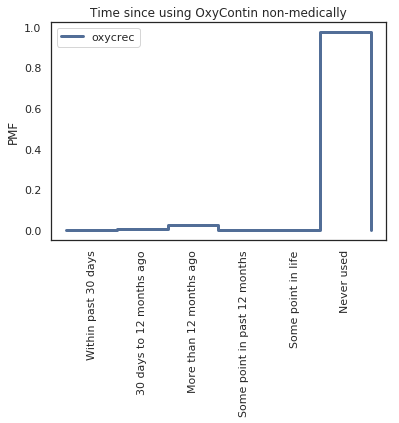

In [246]:
ticks = [i for i in range(1, 7)]
labels = ['Within past 30 days',
          '30 days to 12 months ago',
          'More than 12 months ago',
          'Some point in past 12 months',
          'Some point in life',
          'Never used']

pmf_oxycrec = ts.Pmf(oxy_df_resample['oxycrec'])
thinkplot.Pmf(pmf_oxycrec, label='oxycrec')
plt.xticks(ticks, labels, rotation=90)
plt.ylabel('PMF')
plt.title('Time since using OxyContin non-medically')
plt.legend()

plt.savefig('figures/oxycrec_w_nevers.png')

Because there are so many people who have never used OxyContin, it is hard to get an idea of the distribution of people who have used it. Let's take out the last category and plot the PMF again.

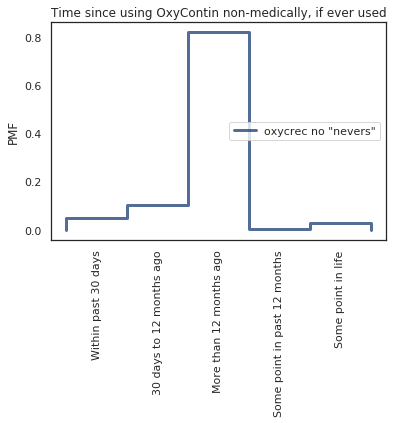

In [255]:
ticks = [i for i in range(1, 6)]
labels = ['Within past 30 days',
          '30 days to 12 months ago',
          'More than 12 months ago',
          'Some point in past 12 months',
          'Some point in life']

oxycrec_ever = oxy_df_resample['oxycrec'].replace([6], np.nan)
pmf_oxycrec_ever = ts.Pmf(oxycrec_ever)
thinkplot.Pmf(pmf_oxycrec_ever, label='oxycrec no "nevers"')
plt.ylabel('PMF')
plt.xticks(ticks, labels, rotation=90)
plt.title('Time since using OxyContin non-medically, if ever used')
plt.legend()

plt.savefig('figures/oxycrec_wo_nevers.png')

Out of the people who reported ever using OxyContin, an overwhelming majority used it over 12 months ago. This is consistent with the finding that respondents were much more likely to use OxyContin non-medically for the first time in their 20s coupled with the finding that a majority of the respondents were over 30 at the time of taking the survey.

### OXYYRTOT: TOTAL # DAYS USED OXYCONTIN PAST 12 MONTHS

This variable represents the number of days in the 12 months prioir to taking the survey the respondents used OxyContin in any way, as directed by a doctor or otherwise. Recall that earlier I replaced any answers corresponding to respondents not having taken OxyContin in the last 12 months or ever in their lives with a 0.

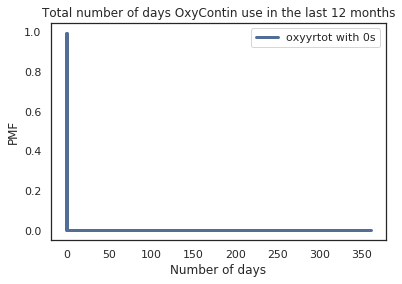

In [258]:
pmf_oxyyrtot = ts.Pmf(oxy_df_resample['oxyyrtot'])
thinkplot.Pmf(pmf_oxyyrtot, label='oxyyrtot with 0s')
plt.ylabel('PMF')
plt.xlabel('Number of days')
plt.title('Total number of days OxyContin use in the last 12 months')
plt.legend()

plt.savefig('figures/oxyyrtot_w_0s.png')

So, as expected, there are a very large number of respondents with 0 days of use. Let's take the zeros out to get an idea of the number of days people who did use OxyContin in the last year used it.

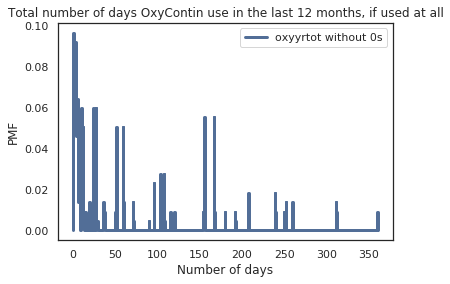

In [261]:
oxyyrtot_no_zeros = oxy_df_resample['oxyyrtot'].replace([0], np.nan)

pmf_oxyyrtot = ts.Pmf(oxyyrtot_no_zeros)
thinkplot.Pmf(pmf_oxyyrtot, label='oxyyrtot without 0s')
plt.ylabel('PMF')
plt.xlabel('Number of days')
plt.title('Total number of days OxyContin use in the last 12 months, if used at all')
plt.legend()

plt.savefig('figures/oxyyrtot_wo_0s_pmf.png')

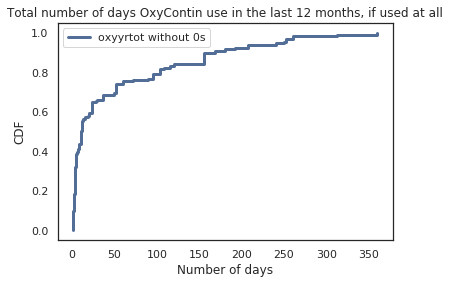

In [263]:
cdf_oxyyrtot = ts.Cdf(oxyyrtot_no_zeros)
thinkplot.Cdf(cdf_oxyyrtot, label='oxyyrtot without 0s')
plt.ylabel('CDF')
plt.xlabel('Number of days')
plt.title('Total number of days OxyContin use in the last 12 months, if used at all')
plt.legend()

plt.savefig('figures/oxyyrtot_wo_0s_pmf.png')

In [267]:
max_days = oxyyrtot_no_zeros.max()
mean = cdf_oxyyrtot.Mean()
median = cdf_oxyyrtot.Value(.5)
iqr = cdf_oxyyrtot.Value(.75) - cdf_oxyyrtot.Value(.25)

print('Max: {}, Mean: {}, Median: {}, IQR: {}'.format(max_days, mean, median, iqr))

Max: 360.0, Mean: 51.97706422018349, Median: 11.0, IQR: 57.0


Again, these plots are consistent with what I would expect. The majority of the respondents who have ever used OxyContin used it less than two weeks out of the year. The data is skewed right with a very long tail, which makes sense because I would expect to see a smaller number of heavier users (these people may be prescribed the drug for severe chronic pain and use it as directed, or have an addiction to the drug to name a couple of scenarios for heavier use).

### OXDAYPYR: # DAYS USED OXYCONTIN "NM" PAST 12 MONTHS

Recall that `OXDAYPYR` differs from `OXYYRTOT` in that it asks how many days the respondents used OxyContin non-medically only instead of any use. Also recall that I replaced the same categories as with `OXYYRTOT` with 0s. I expect to see more 0s in the PMF of this variable, so we probably will have to look at the PMF for only people who have used OxyContin nonmedically in the past 12 months.

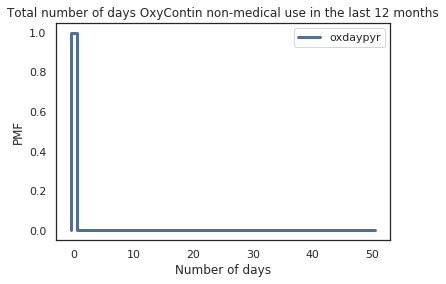

In [270]:
pmf_oxdaypyr = ts.Pmf(oxy_df_resample['oxdaypyr'])
thinkplot.Pmf(pmf_oxdaypyr, label='oxdaypyr')
plt.ylabel('PMF')
plt.xlabel('Number of days')
plt.title('Total number of days OxyContin non-medical use in the last 12 months')
plt.legend()

plt.savefig('figures/oxdaypyr_w_0s_pmf.png')

As expected, the 0s dominate the pmf. Let's take a look at only the respondents who did use OxyContin non-medically in the 12 months prior to taking the survey.

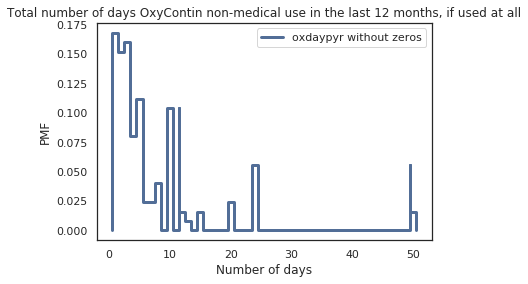

In [272]:
oxdaypyr_no_zeros = oxy_df_resample['oxdaypyr'].replace([0], np.nan)

pmf_oxdaypyr = ts.Pmf(oxdaypyr_no_zeros)
thinkplot.Pmf(pmf_oxdaypyr, label='oxdaypyr without zeros')
plt.ylabel('PMF')
plt.xlabel('Number of days')
plt.title('Total number of days OxyContin non-medical use in the last 12 months, if used at all')
plt.legend()

plt.savefig('figures/oxdaypyr_wo_0s_pmf.png')

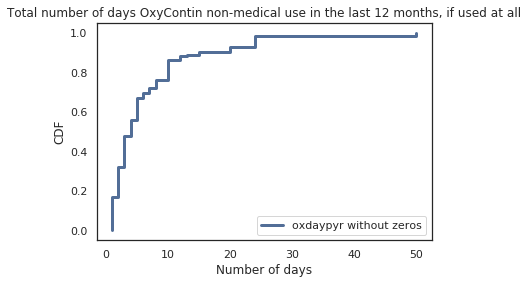

In [274]:
cdf_oxdaypyr = ts.Cdf(oxdaypyr_no_zeros)
thinkplot.Cdf(cdf_oxdaypyr, label='oxdaypyr without zeros')
plt.ylabel('CDF')
plt.xlabel('Number of days')
plt.title('Total number of days OxyContin non-medical use in the last 12 months, if used at all')
plt.legend()

plt.savefig('figures/oxdaypyr_wo_0s_cdf.png')

In [276]:
max_days = oxdaypyr_no_zeros.max()
mean = cdf_oxdaypyr.Mean()
median = cdf_oxdaypyr.Value(.5)
iqr = cdf_oxdaypyr.Value(.75) - cdf_oxdaypyr.Value(.25)

print('Max: {}, Mean: {}, Median: {}, IQR: {}'.format(max_days, mean, median, iqr))

Max: 50.0, Mean: 6.664000000000001, Median: 4.0, IQR: 6.0


Like the distribution for `OXYYRTOT`, this distribution is also skewed right. The majority of people who took OxyContin non-medically in the past 12 months took it for less than a week total. It is interesting to note that the maximum number of days respondents took it non-medically is 50, as opposed to 360 in the previous section. I can imagine a couple of reasons why. One is that people who used OxyContin non-medically had a prescription, or knew someone with a prescription, and they may have used it non-medically for a temporary severe pain they were experiencing instead of going to the doctor. I have anecdotal evidence from several aquaintences that is consistent with this guess. Another reason may be that it is more difficult to obtain OxyContin so regularly without a prescription, so people are much less likely to use the drug frequently unless they have a medical reason to use it. A final reason may be that OxyContin is very strong, and people with opioid dependencies may be more likely to use a less strong drug more frequently. This would require more data on other types of opioids to test.

## Relationships by Age

I want to see if there is a relationship between the age of respondents and the age that the respondents reported first trying OxyContin non medically for the first time. I think this could provide some insights into if there is an increasing problem with non-medical OxyContin use, and if there is, which age group is most at risk.

Let's take a look at the CDFs of `OXYCAGE` for the age groups I defined earlier. Recall that I grouped all respondents under 20 into one group, and I grouped all respondents in their 20s together into another age group.

In [277]:
# Print categories for reference.
print(age_cat_dict)

{'1 - Respondent is 12 years old': 1, '2 - Respondent is 13 years old': 2, '3 - Respondent is 14 years old': 3, '4 - Respondent is 15 years old': 4, '5 - Respondent is 16 years old': 5, '6 - Respondent is 17 years old': 6, '7 - Respondent is 18 years old': 7, '8 - Respondent is 19 years old': 8, '9 - Respondent is 20 years old': 9, '10 - Respondent is 21 years old': 10, '11 - Respondent is 22 or 23 years old': 11, '12 - Respondent is 24 or 25 years old': 12, '13 - Respondent is between 26 and 29 years old': 13, '14 - Respondent is between 30 and 34 years old': 14, '15 - Respondent is between 35 and 49 years old': 15, '16 - Respondent is between 50 and 64 years old': 16, '17 - Respondent is 65 years old or older': 17}


In [279]:
# Select rows based on age groups.
oxycage_under_20 = oxy_df_resample[(oxy_df_resample['AGE2'] < 9)]
oxycage_20s = oxy_df_resample[(oxy_df_resample['AGE2'] >= 9) & (oxy_df_resample['AGE2'] < 14)]
oxycage_30_34 = oxy_df_resample[(oxy_df_resample['AGE2'] == 14)]
oxycage_35_49 = oxy_df_resample[(oxy_df_resample['AGE2'] == 15)]
oxycage_50_64 = oxy_df_resample[(oxy_df_resample['AGE2'] == 16)]
oxycage_65 = oxy_df_resample[(oxy_df_resample['AGE2'] == 17)]

In [306]:
def create_cdf_oxycage(df, label, age_range_string, figure_name):
    """Make and format a CDF plot of oxycage for an age group
    
    Args:
        df: A dataframe of selected rows for the desired age group.
        label: The label for the plot legend.
        age_range_string: An age range to use for formatting the
            title of the plot.
        figure_name: The file name of the saved figure. Does not
            include the directory or file extension.
    """
    cdf = ts.Cdf(df['oxycage'])
    thinkplot.Cdf(cdf, label=label)
    plt.ylabel('CDF')
    plt.xlabel('Age (years)')
    plt.title('Age of first using OxyContin non-medically for ages {}'.format(age_range_string))
    plt.legend()
    plt.savefig('figures/{}.png'.format(figure_name))
    
    min_age = df['oxycage'].min()
    max_age = df['oxycage'].max()
    mean = cdf.Mean()
    median = cdf.Value(.5)
    iqr = cdf.Value(.75) - cdf.Value(.25)
    
    print("Min: {}, Max: {}, Mean: {}, Median {}, IQR: {}".format(min_age, max_age, mean, median, iqr))

Min: 10.0, Max: 19.0, Mean: 15.281249999999998, Median 16.0, IQR: 3.0


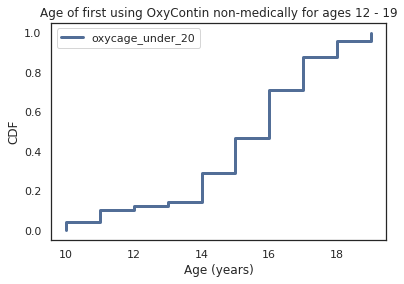

In [307]:
create_cdf_oxycage(oxycage_under_20, 'oxycage_under_20', '12 - 19', 'oxycage_under_20')

Min: 12.0, Max: 28.0, Mean: 19.05535714285714, Median 19.0, IQR: 4.0


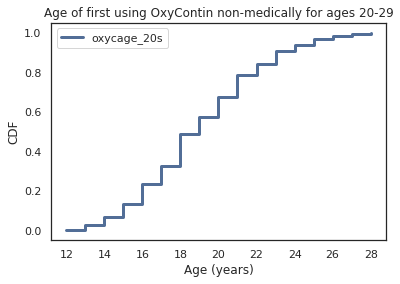

In [308]:
create_cdf_oxycage(oxycage_20s, 'oxycage_20s', '20-29', 'oxycage_20s')

Min: 13.0, Max: 34.0, Mean: 22.35390946502058, Median 22.0, IQR: 6.0


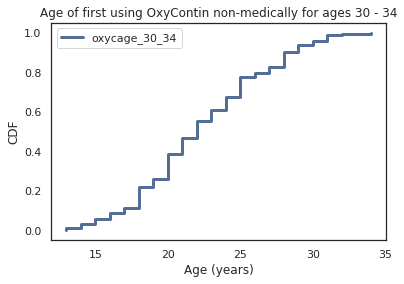

In [309]:
create_cdf_oxycage(oxycage_30_34, 'oxycage_30_34', '30 - 34', 'oxycage_30_34')

Min: 12.0, Max: 45.0, Mean: 29.20414201183431, Median 29.0, IQR: 10.0


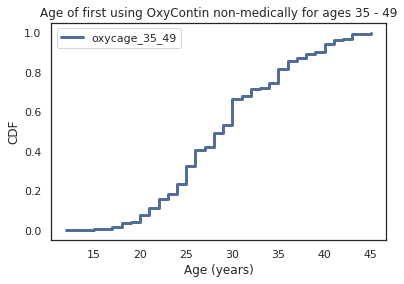

In [310]:
create_cdf_oxycage(oxycage_35_49, 'oxycage_35_49', '35 - 49', 'oxycage_35_49')

Min: 12.0, Max: 57.0, Mean: 38.44886363636364, Median 40.0, IQR: 17.0


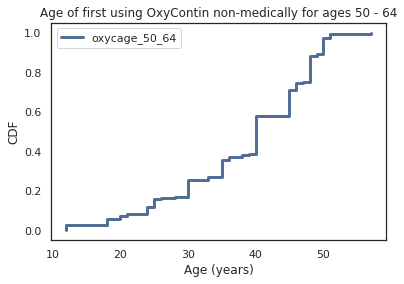

In [311]:
create_cdf_oxycage(oxycage_50_64, 'oxycage_50_64', '50 - 64', 'oxycage_50_64')

Min: 20.0, Max: 60.0, Mean: 40.416666666666664, Median 35.0, IQR: 35.0


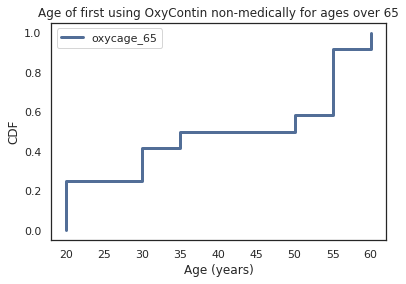

In [312]:
create_cdf_oxycage(oxycage_65, 'oxycage_65', 'over 65', 'oxycage_65')

There are some aspects of these CDFs that are expected. The first is that the maximum age increases with the ages represented. This makes sense because of the upper bounds of the age range. People cannot report having tried OxyContin non-medically for the first time at an age greater than the age they were when they took the survey. It might be worth noting that the three youngest age groups have a maximum that is within 1 year of the oldest respondents in the group, and the three older age groups have a larger gap between the maximum value and the oldest age represented by the group. This is consistent with the fact that people are more likely to try OxyContin non-medically for the first time in their 20s.

The plot below shows that these differences increase with older age groups. Please note that the last data point is based on the minimum age of the last age group because it does not have an upper bound. The plot is merely illustrative of the magnitude of the differences.

Text(0.5, 0, 'Max age in age range')

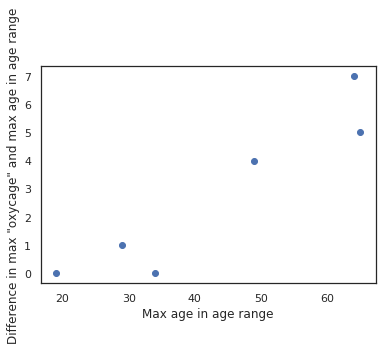

In [316]:
max_ages = np.array([19, 29, 34, 49, 64, 65])
max_values = np.array([19, 28, 34, 45, 57, 60])

plt.scatter(max_ages, max_ages - max_values)
plt.ylabel('Difference in max "oxycage" and max age in age range')
plt.xlabel('Max age in age range')

Another aspect of the CDFs to point out is that the distributions for age ranges 20-29, 30-34, and 35-49 all appear to be roughly the same shape. This is also expected because these groups are young enough to have tried OxyContin for the first time in the IQR of ages that all respondents have tried OxyContin non-medically for the first time. The FDA approved OxyContin in 1995 ([source](https://www.fda.gov/drugs/drugsafety/informationbydrugclass/ucm338566.htm)). So, someone who was 34 years old in 2014 would have been about 15 in 1995.

Interestingly, all age groups have a minimum between 10 and 13, except for the oldest group. So, that indicates that some participants reported trying the drug before it was available. The wording of the question, according to the codebook, is "How old were you the first time you used OxyContin that was not prescribed for you or that you took only for the experience or feeling it caused?"

Another interesting point about the minimums of these age groups is that the youngest age group also has the smallest minimum, at 10. I think if I were to look at multiple years of the NSDUH survey, I would investigate if this minimum is consistently smaller than the minimums of the other age groups. If it is, and this is a statistically significant result, that might indicate that people are trying OxyContin at increasingly younger ages.

## Non-medical vs Medical Use by Respondents
For respondents who have ever used oxy, make a scatter plot of days using it nonmedically vs days using it medically (subtract)

I noted earlier that the variables `OXYYRTOT` (any OxyContin use in the past 12 months) and `OXDAYPYR` (non-medical OxyContin use in the past 12 months) follow similar patterns, but the maximum and median number of days that people used OxyContin non-medically is smaller than for any OxyContin use. I think that there could be a relationship between these two variables. Let's take a look at the scatter plot of `OXDAYPYR` (for respondents who used OxyContin in the past year) vs `OXYYRTOT` for respondents

50.0


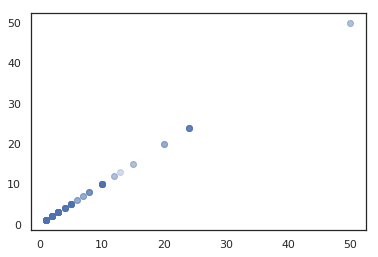

In [331]:
subset = oxy_df_resample.dropna(subset=['oxyyrtot', 'oxdaypyr'])
oxyyrtot = subset['oxyyrtot'].replace([0], np.nan)
oxdaypyr = subset['oxdaypyr'].replace([0], np.nan)
print(oxyyrtot.max())

plt.scatter(oxyyrtot, oxdaypyr, alpha=0.25)

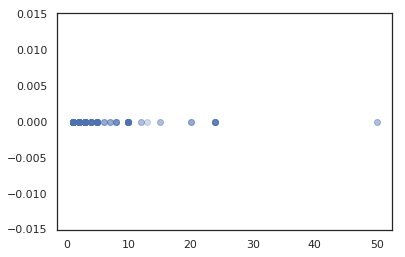

In [333]:
plt.scatter(oxyyrtot, oxyyrtot - oxdaypyr, alpha=0.25)

This relationship looks surprisingly linear, which indicates that the people who answered a number of days for both questions tended to answer the same number of days. I was expecting to see that some people would have used OxyContin both medically and non-medically, so I'm surprised by this. I don't think I have sufficient data to further explore this question, but if I were to explore multiple years of NSDUH data in the future, I would revisit this question to see if this is consistent across years.